In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import imageio
import cv2
import warnings
warnings.filterwarnings('ignore')

In [2]:
xs = []
ys = []

#points to the end of the last batch
train_batch_pointer = 0
val_batch_pointer = 0

#read data.txt
with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)
print("Total number of images: ",num_images)
#Splitting data into train and validation
train_xs = xs[:int(len(xs) * 0.8)]
train_ys = ys[:int(len(xs) * 0.8)]

val_xs = xs[-int(len(xs) * 0.2):]
val_ys = ys[-int(len(xs) * 0.2):]

num_train_images = len(train_xs)
num_val_images = len(val_xs)
print("Number of images in train dataset: ",num_train_images)
print("Number of images in test dataset: ", num_val_images)

Total number of images:  45406
Number of images in train dataset:  36324
Number of images in test dataset:  9081


## Histogram of steeing angles from train and validation data

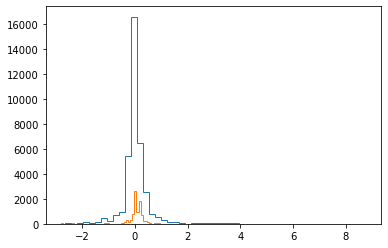

In [3]:
plt.hist(train_ys,bins=50,histtype='step')
plt.hist(val_ys,bins=50,histtype='step')
plt.show()

## Observations:
* Histogram of train and validation is not fully overlapped which is obvious because the distribution of angles in first 80% of data may differ from the distribution of angles on rest 20% of data depending on the road.
* There is some difference in train and validation data.
* Most of the times steering angle is at 0 for both train and validation data.
* Most of the values of steering angles lie in the range of -2 to +2.

## Building a baseline model

In [4]:
trained_mean = np.mean(train_ys)

print("Test MSE(Mean): ",np.mean(np.square(val_ys - trained_mean)))
print("Test MSE(Zero): ", np.mean(np.square(val_ys - np.zeros_like(val_ys))))

Test MSE(Mean):  0.19114218828169288
Test MSE(Zero):  0.1909079388457136


In [5]:
def datagenerator(data):
    """This function reads each image from input data and returns as normalized numpy array"""
    data_processed = []
    for i in range(len(data)):
        img = imageio.imread(data[i])[-150:]
        img = np.array(Image.fromarray(img).resize((66,200)))
        data_processed.append(np.divide(img,255.0))
    return np.asarray(data_processed)
#Preprocessing data
train = datagenerator(train_xs)
validation = datagenerator(val_xs)    

## Building model

In [6]:
input_shape = (66, 200, 3)

model = keras.Sequential()
#Adding 5 x 5 convoultion layers
model.add(keras.layers.Conv2D(24,(5,5),activation='relu'))
model.add(keras.layers.Conv2D(36,(5,5),activation='relu'))
model.add(keras.layers.Conv2D(48,(5,5),activation='relu'))
#Adding 3 x 3 convoultion layers
model.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(keras.layers.Flatten())
#Adding Dense layers
# Adding dropouts for better accuracy
model.add(keras.layers.Dense(100,activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(50,activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(10,activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(1,activation='linear'))

In [7]:
#Compiling model
model.compile(optimizer='adam',loss='mse')

In [8]:
#Training model
model.fit(x=train, y=np.asarr nmay(train_ys),epochs=5)
#Predicting steering angles for validation data
y_predicted = model.predict(validation)
#Saving model
model.save('model/')

Epoch 1/5
1136/1136 [==============================] - 10844s 10s/step - loss: 0.3626
Epoch 2/5
1136/1136 [==============================] - 10631s 9s/step - loss: 0.3163
Epoch 3/5
1136/1136 [==============================] - 10187s 9s/step - loss: 0.3163
Epoch 4/5
1136/1136 [==============================] - 9924s 9s/step - loss: 0.3163
Epoch 5/5
1136/1136 [==============================] - 9561s 8s/step - loss: 0.3163
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model/assets


In [29]:
img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape

smoothed_angle = 0

cap = cv2.VideoCapture(0)
while(cv2.waitKey(10) != ord('q')):
    ret, frame = cap.read()
    image = scipy.misc.imresize(frame, [66, 200]) / 255.0
    degrees = model.y.eval(feed_dict={model.x: [image], model.keep_prob: 1.0})[0][0] * 180 / scipy.pi
    call("clear")
    print("Predicted steering angle: " + str(degrees) + " degrees")
    cv2.imshow('frame', frame)
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-smoothed_angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    cv2.imshow("steering wheel", dst)

cap.release()
cv2.destroyAllWindows()


error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-memyuvq3\opencv\modules\highgui\src\window.cpp:717: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvWaitKey'
